# **Understanding and Predicting Property Maintenance Fines**

*[Based on the Applied Machine Learning Course by University of Michigan](https://www.coursera.org/learn/python-machine-learning)*


*by Abdurrahman Shiddiq Thaha*

*October 2020*

---

## Content

1. Business Understanding
    * Objective
    * Description
2. Data Understanding
    * Import Libraries
    * Load data
    * Hypothesis Generation
    * EDA
3. Data Preparation
    * Data Concating, Encoding and Filling
4. Modeling and Evaluation
    * Baseline Model
    * Machine Learning Model
5. Deployment

# 1. Business Understanding

## 1.1 Objective
predict whether a given blight ticket will be paid on time

## 1.2 Description
The Michigan Data Science Team ([MDST](https://midas.umich.edu/educational/mdst-announces-detroit-blight-data-challenge-organizational-meeting-feb-16/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. Blight violations are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. All data for this assignment has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/). **Only the data already included in your Coursera directory can be used for training the model for this assignment**

# 2. Data Understanding

## 2.1 Import Libraries

In [264]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# sets the style for the plotting
plt.style.use('seaborn-dark')

import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold

# to execute all of the syntaxes given in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.simplefilter('ignore')

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.dummy import DummyClassifier

## 2.2 Load Data

We have been provided three files. A description for what each of these files contain is given below:


1.     **train.csv**: the training set (all tickets issued 2004-2011)
2.     **test.csv**: the test set (all tickets issued 2012-2016)
3.     **addresses.csv & latlons.csv**: mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 

### **Data Description**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant

In [2]:
train = pd.read_csv('data/train.csv', engine='python')
test = pd.read_csv('data/test.csv')
address = pd.read_csv('data/addresses.csv')
latlon = pd.read_csv('data/latlons.csv')

## 2.3 Hypothesis Generation
Simply put, a hypothesis is a possible view or assertion of an analyst about the problem he or she is working upon. It may be true or may not be true.

* **Does agency affect whether the fine will be paid on time** ?
* **Does location affect whether whether the fine will be paid on time?**
* **Does any particular time and date affect whether the fine will be paid on time?**
* **Does any particular type of violation affect whether the fine will be paid on time?**
* **Do the fine amount and judgment amount affect whether the fine will be paid on time?**
* **is getting a discount affect whether the fine will be paid on time?**

## 2.4 EDA

### **Brief exploration on our training and test datasets**

#### **Take a peek at the dataset**

In [3]:
train.head(2)
test.head(2)
address.head(2)
latlon.head(2)

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,...,0.0,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,...,0.0,855.0,780.0,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0


,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,grafitti_status
0,284932,Department of Public Works,"Granberry, Aisha B","FLUELLEN, JOHN A",10041.0,ROSEBERRY,NaN,141,ROSEBERRY,DETROIT,...,Failure to secure City or Private solid waste ...,Responsible by Default,200.0,20.0,10.0,20.0,0.0,0.0,250.0,NaN
1,285362,Department of Public Works,"Lusk, Gertrina","WHIGHAM, THELMA",18520.0,EVERGREEN,NaN,19136,GLASTONBURY,DETROIT,...,Allowing bulk solid waste to lie or accumulate...,Responsible by Default,1000.0,20.0,10.0,100.0,0.0,0.0,1130.0,NaN


,ticket_id,address
0,22056,"2900 tyler, Detroit MI"
1,27586,"4311 central, Detroit MI"


,address,lat,lon
0,"4300 rosa parks blvd, Detroit MI 48208",42.346169,-83.079962
1,"14512 sussex, Detroit MI",42.394657,-83.194265


#### **Dataset Shape**

In [4]:
ID_COL, TARGET_COL = 'ticket_id', 'compliance'

In [5]:
print(f'\nTrain contains {train.shape[0]} samples and {train.shape[1]} variables')
print(f'\nTrain contains {test.shape[0]} samples and {test.shape[1]} variables')

features = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]
print(f'\nThe dataset contains {len(features)} features\n')


Train contains 250306 samples and 34 variables

Train contains 61001 samples and 27 variables

The dataset contains 32 features



#### **Target Distribution**

In [6]:
train[TARGET_COL].value_counts()

0.0    148283
1.0     11597
Name: compliance, dtype: int64

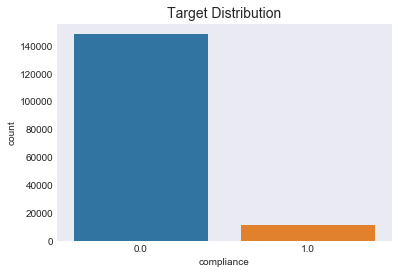

In [7]:
_ = sns.countplot(train[TARGET_COL])
_ = plt.title("Target Distribution", fontsize=14)

#### **Variable Types**

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250306 entries, 0 to 250305
Data columns (total 34 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   ticket_id                   250306 non-null  int64  
 1   agency_name                 250306 non-null  object 
 2   inspector_name              250306 non-null  object 
 3   violator_name               250272 non-null  object 
 4   violation_street_number     250306 non-null  float64
 5   violation_street_name       250306 non-null  object 
 6   violation_zip_code          0 non-null       float64
 7   mailing_address_str_number  246704 non-null  float64
 8   mailing_address_str_name    250302 non-null  object 
 9   city                        250306 non-null  object 
 10  state                       250213 non-null  object 
 11  zip_code                    250305 non-null  object 
 12  non_us_str_code             3 non-null       object 
 13  country       

#### **Null Values**

In [9]:
null_values_per_variable = 100 * (train.isnull().sum()/train.shape[0]).round(3)
null_values_per_variable.sort_values(ascending=False)

violation_zip_code            100.0
grafitti_status               100.0
non_us_str_code               100.0
collection_status              85.3
payment_date                   83.6
compliance                     36.1
hearing_date                    5.0
mailing_address_str_number      1.4
violator_name                   0.0
violation_street_number         0.0
ticket_issued_date              0.0
inspector_name                  0.0
mailing_address_str_name        0.0
city                            0.0
state                           0.0
zip_code                        0.0
agency_name                     0.0
country                         0.0
violation_street_name           0.0
violation_code                  0.0
compliance_detail               0.0
violation_description           0.0
disposition                     0.0
fine_amount                     0.0
admin_fee                       0.0
state_fee                       0.0
late_fee                        0.0
discount_amount             

#### **Unique values in each variable**

In [10]:
train.nunique()

ticket_id                     250306
agency_name                        5
inspector_name                   173
violator_name                 119992
violation_street_number        19175
violation_street_name           1791
violation_zip_code                 0
mailing_address_str_number     15826
mailing_address_str_name       37896
city                            5184
state                             59
zip_code                        4251
non_us_str_code                    2
country                            5
ticket_issued_date             86979
hearing_date                    6222
violation_code                   235
violation_description            258
disposition                        9
fine_amount                       43
admin_fee                          2
state_fee                          2
late_fee                          37
discount_amount                   13
clean_up_cost                      1
judgment_amount                   57
payment_amount                   533
b

### **Analyzing Each Variable & their relationships**

There are 4 types of features that we have:

1. Numerical
2. Categorical
3. Textual
4. DateTime


Also our target is Continuous

For each feature type we will be perform two types of analysis:

1. Univariate: Analyze 1 feature at a time

2. Bivariate: Analyze the relationship of that feature with target variable, i.e. 'likes'

### **Numerical Variables**

In [11]:
num_cols = ['fine_amount','admin_fee', 'state_fee', 'late_fee', 'discount_amount', 'judgment_amount']

#### **Univariate Analysis**

**Boxplots**

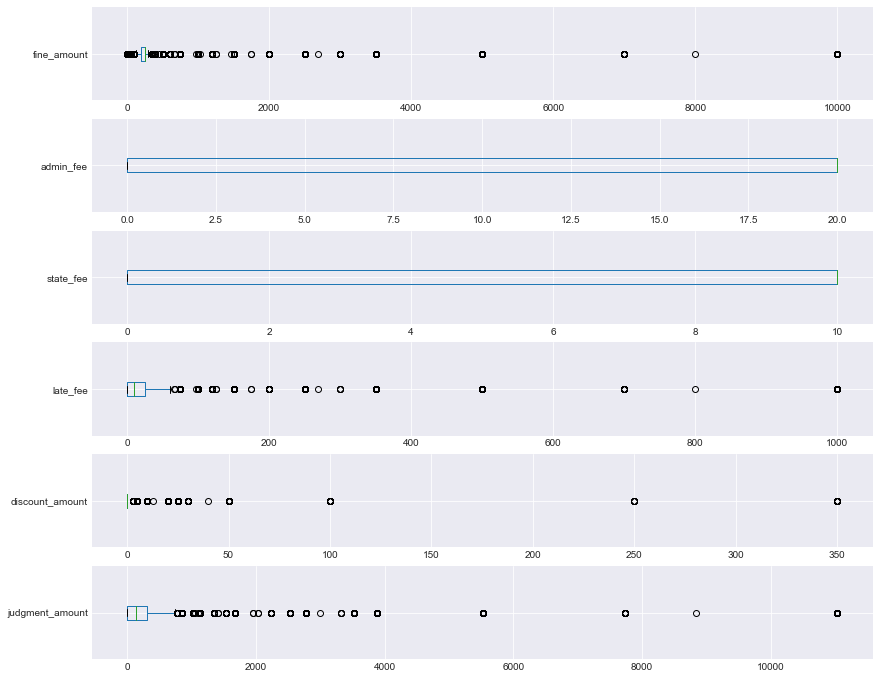

In [12]:
fig, axes = plt.subplots(6, 1, figsize=(14, 12))
for c, ax in zip(num_cols, axes):
    _ = train[[c]].boxplot(ax=ax, vert=False)

**Histogram**

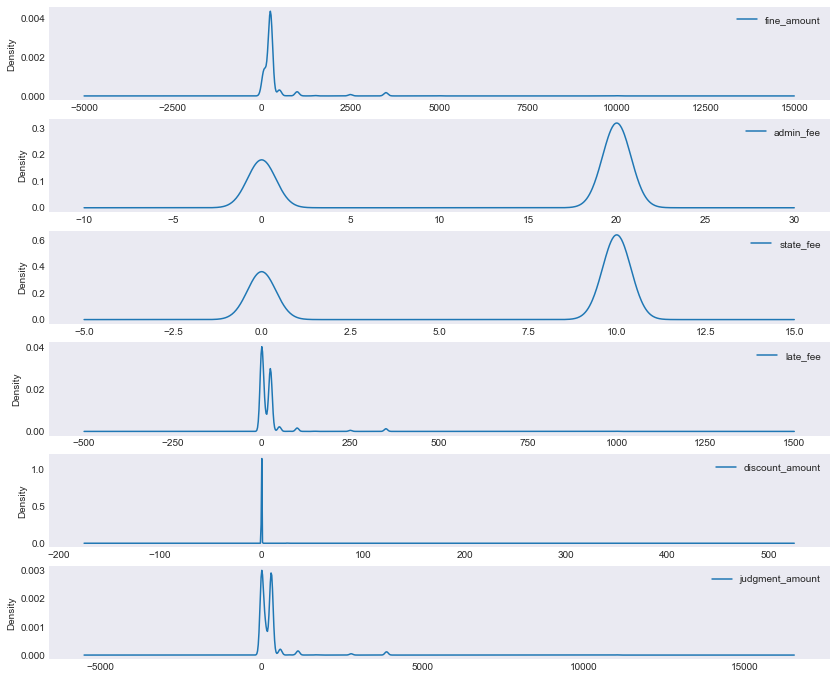

In [13]:
fig, axes = plt.subplots(6, 1, figsize=(14, 12))
for c, ax in zip(num_cols, axes):
    _ = train[[c]].plot(ax=ax, kind='kde')

#### **Bivariate Analysis**

**Horizontal BarPlots**

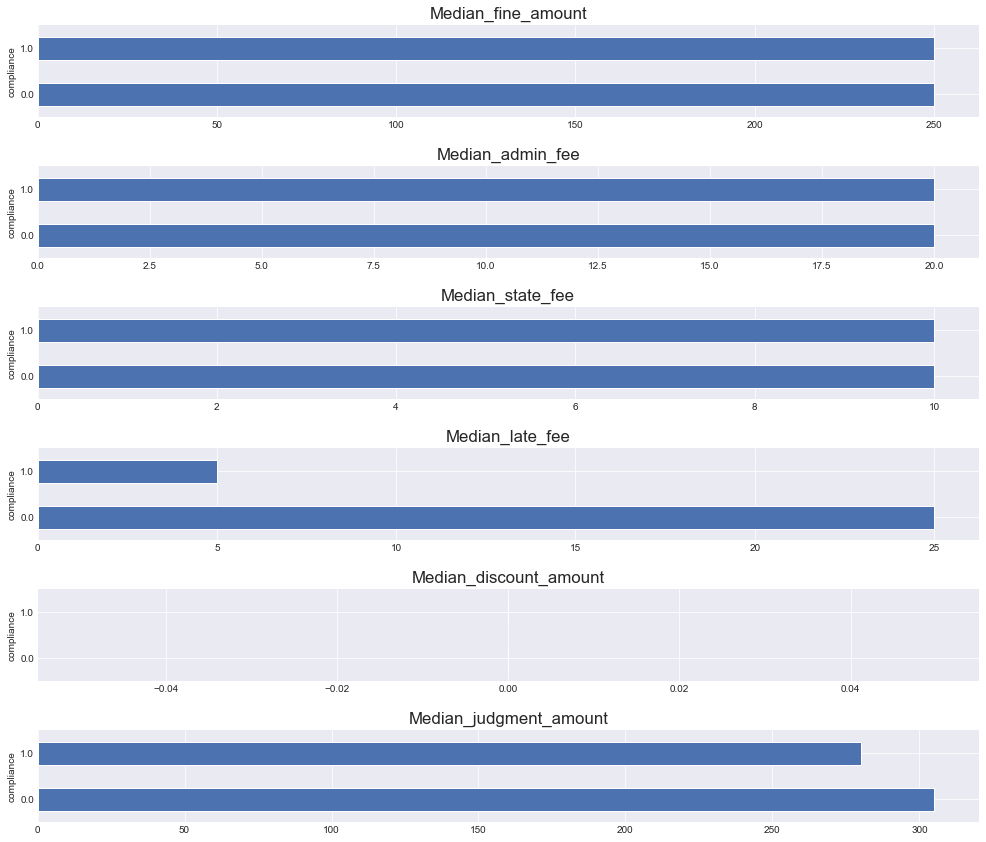

In [14]:
fig, axes = plt.subplots(6, 1, figsize=(14, 12))
sns.set(font_scale=1.4)
for c, ax in zip(num_cols, axes):
    _ = train.groupby('compliance')[c].median().plot(kind = 'barh', ax=ax, title = f'Median_{c}')

plt.tight_layout()

**Q. Do the fine amount and judgment amount affect whether the fine will be paid on time?**

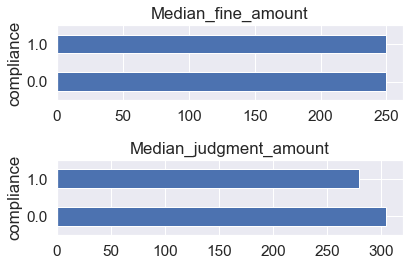

In [15]:
fig, axes = plt.subplots(2, 1)
_ = train.groupby('compliance')['fine_amount'].median().plot(ax=axes[0], kind = 'barh', title = f'Median_fine_amount')
_ = train.groupby('compliance')['judgment_amount'].median().plot(ax=axes[1], kind = 'barh', title = f'Median_judgment_amount')
plt.tight_layout()

**Q. is getting a discount affect whether the fine will be paid on time?**

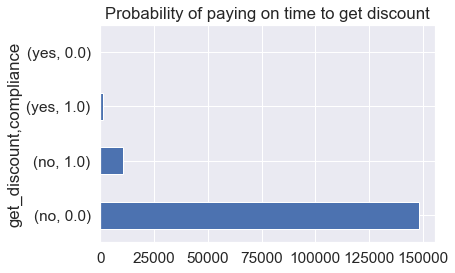

In [19]:
train['get_discount'] = 'yes'
train.loc[train['discount_amount']==0, 'get_discount'] = 'no'

_ = train.groupby('get_discount')['compliance'].value_counts().plot(kind='barh', title='Probability of paying on time to get discount')

**Correlation HeatMaps**

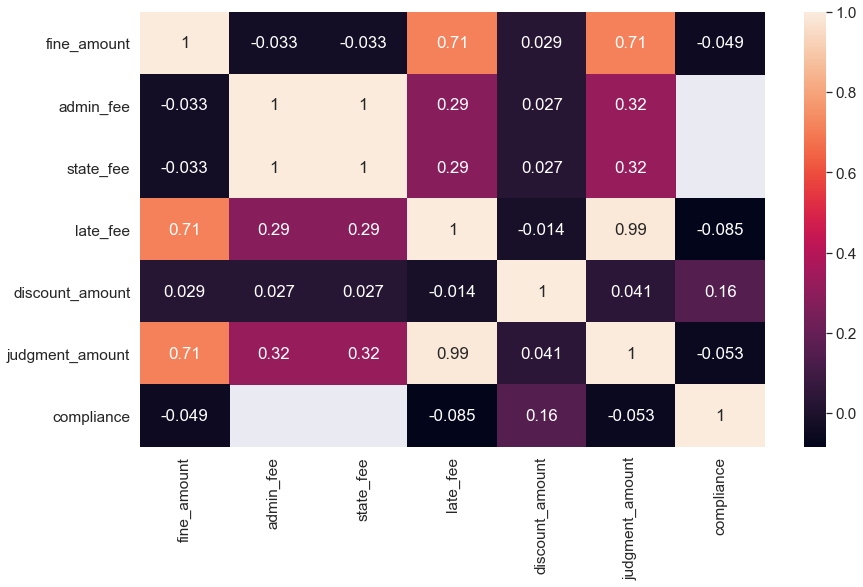

In [20]:
plt.figure(figsize=(14,8))
sns.set(font_scale=1.4)
_ = sns.heatmap(train[num_cols + ['compliance']].corr(), annot=True);

### **Categorical Variables**

In [24]:
cat_cols = ['agency_name', 'violator_name', 'inspector_name', 'violation_street_name', 'city', 'state', 'zip_code', 'violation_code', 'disposition']

#### **Univariate Analysis**

**Pie Chart**

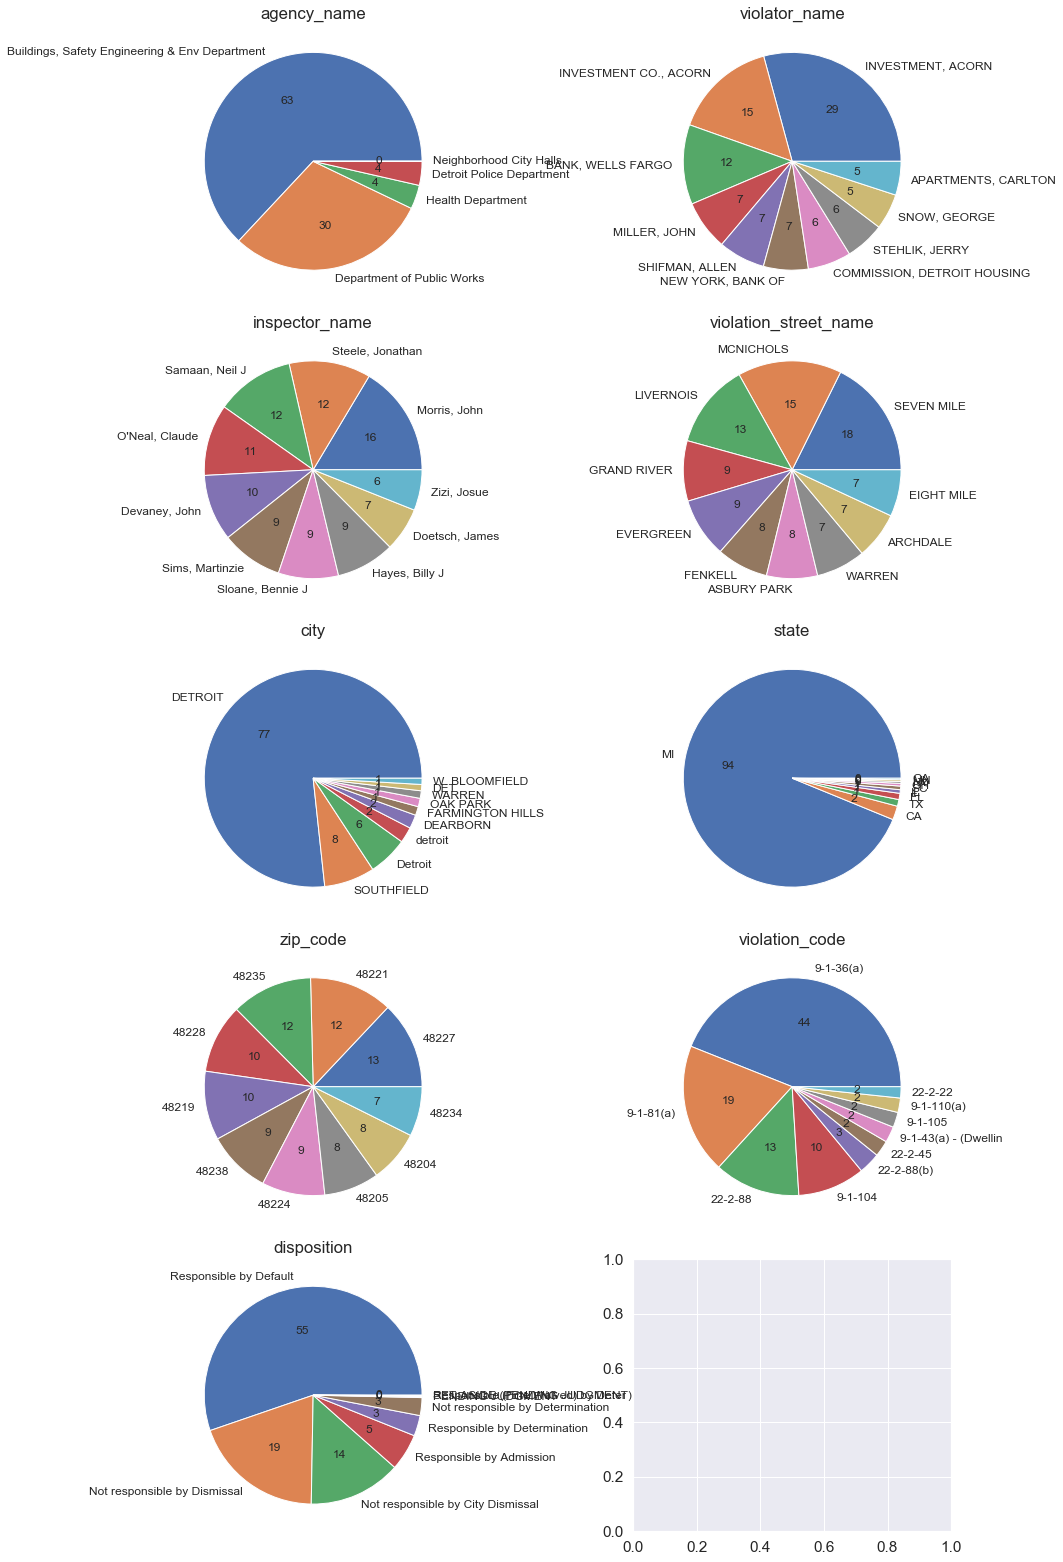

In [25]:
fig, axes = plt.subplots(5, 2, figsize=(14,22))

axes = [ax for axes_row in axes for ax in axes_row]

for c, ax in zip(cat_cols, axes):
    _ = train[c].value_counts().sort_values(ascending=False)[:10].plot(kind='pie', ax=ax, title=c, fontsize=12, autopct='%.0f')
    _ = ax.set_ylabel('')
    
_ = plt.tight_layout()

**CountPlots**

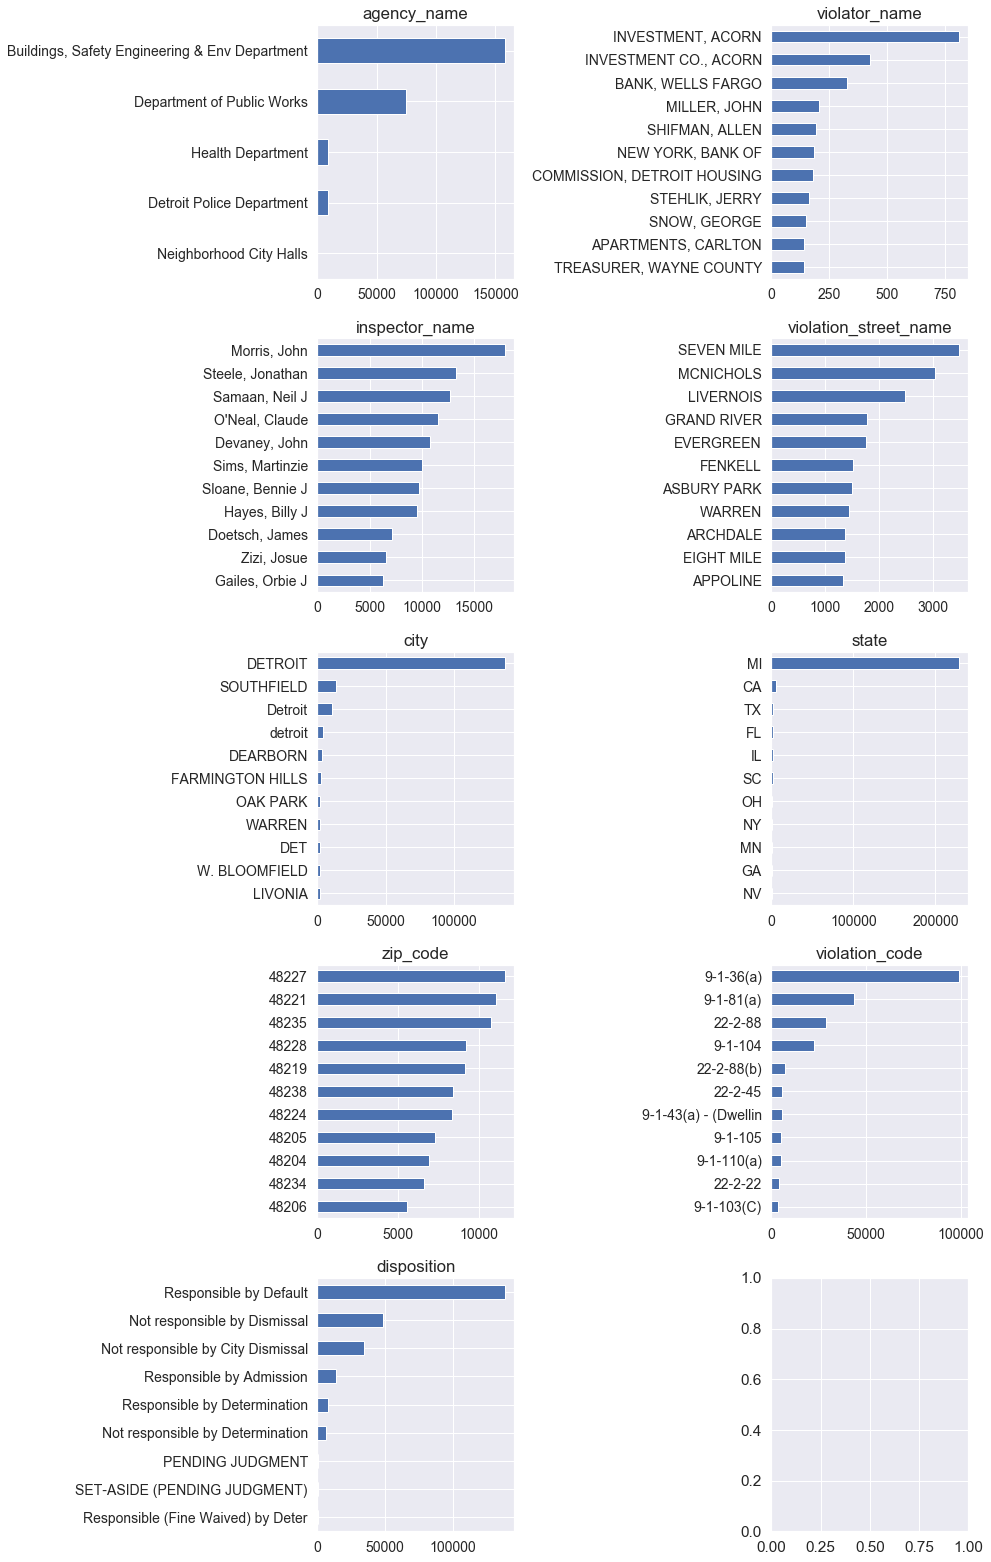

In [26]:
fig, axes = plt.subplots(5, 2, figsize=(14, 22))
axes = [ax for axes_row in axes for ax in axes_row]

for c, ax in zip(train[cat_cols], axes):
    _ = train[c].value_counts().sort_values(ascending=False)[10::-1].plot(kind='barh', ax=ax, title=c, fontsize=14)
    
_ = plt.tight_layout()

#### **Bivariate Analysis**

**Bivariate Analysis Relationships with Target**

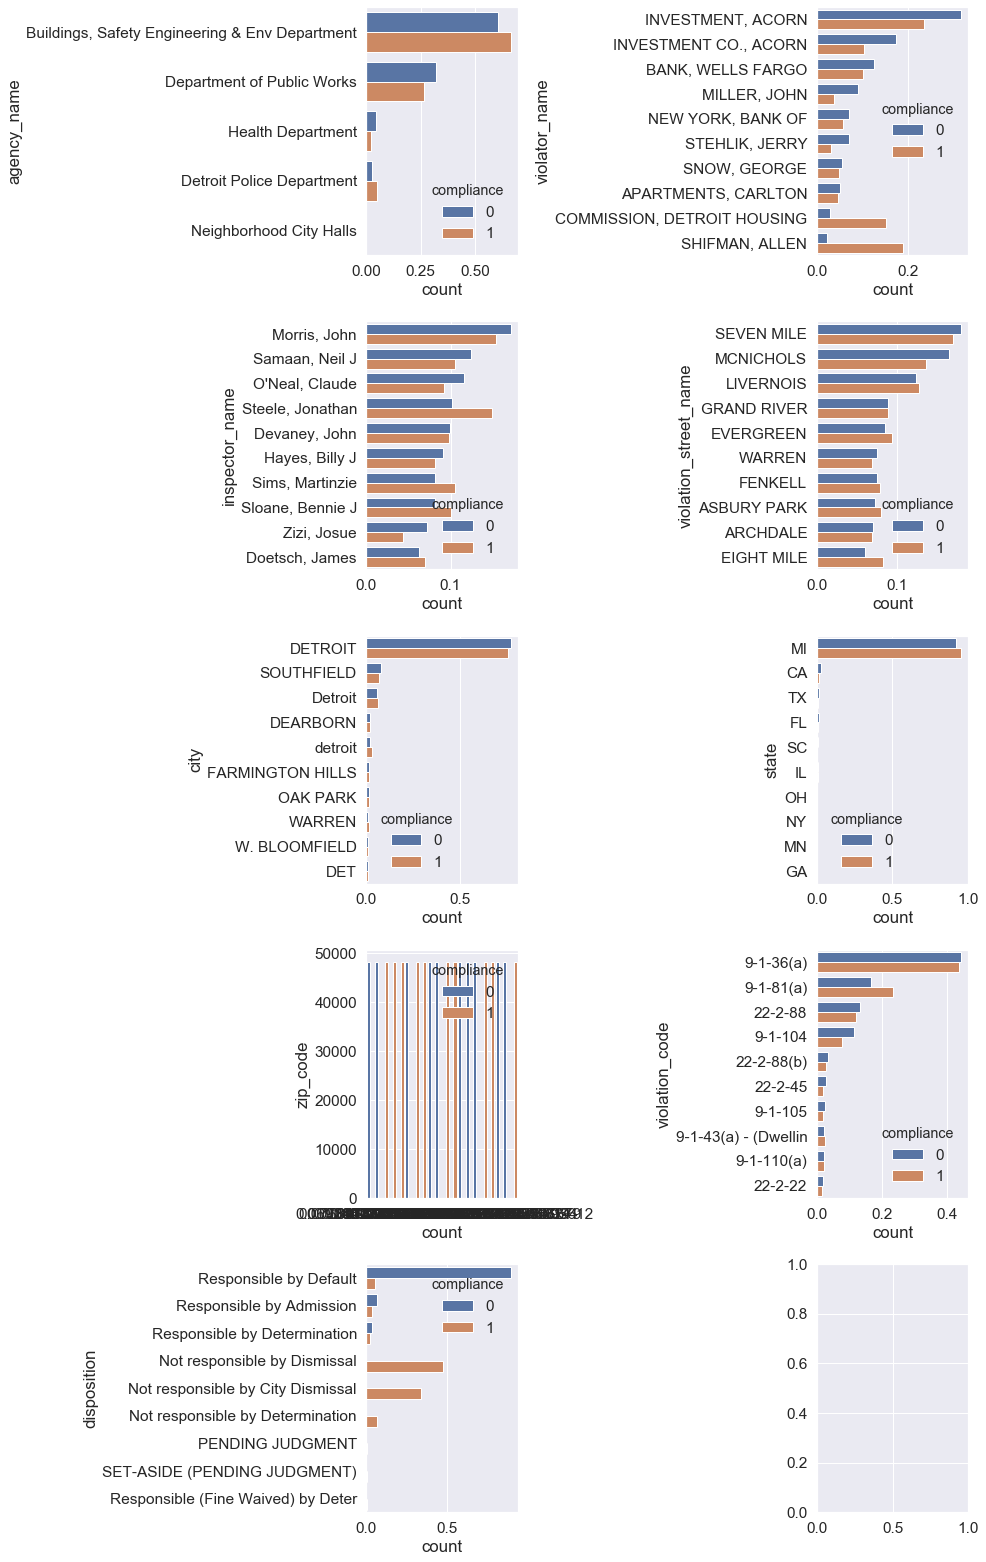

In [29]:
fig, axes = plt.subplots(5, 2, figsize=(14, 22))
axes = [ax for axes_row in axes for ax in axes_row]

for c, ax in zip(train[cat_cols], axes):
    row = train[c].value_counts().sort_values(ascending=False)[:10]
    fltr0 = (train[TARGET_COL] == 0.0) & (train[c].isin(row.index))
    fltr1 = (train[TARGET_COL] != 0.0) & (train[c].isin(row.index))
    vc_a = train[fltr0][c].value_counts(normalize=True).reset_index().rename({'index' : c, c: 'count'}, axis=1)
    
    vc_b = train[fltr1][c].value_counts(normalize=True).reset_index().rename({'index' : c, c: 'count'}, axis=1)

    vc_a[TARGET_COL] = 0
    vc_b[TARGET_COL] = 1

    df = pd.concat([vc_a, vc_b]).reset_index(drop = True)    
    
    _ = sns.barplot(y = c, x = 'count', data =df , hue=TARGET_COL, ax=ax)
    
_ = plt.tight_layout()

# 3. Data Preparation



In [30]:
ID_COL, TARGET_COL = 'ticket_id', 'compliance'
features = [c for c in test.columns if c not in [ID_COL, TARGET_COL]]

cat_cols = ['agency_name', 
            'inspector_name', 
            'state', 
            'violation_code', 
            'disposition']

num_cols = ['fine_amount', 
            'discount_amount',  
            'late_fee',
            'lat',
            'lon']

Dropping 'not responsible' target value 

In [31]:
train.drop(train[train[TARGET_COL].isnull()].index, inplace=True)

In [32]:
df_latlon = pd.merge(latlon, address, how='inner', on='address')

In [34]:
df_latlon.head(2)

,address,lat,lon,ticket_id
0,"4300 rosa parks blvd, Detroit MI 48208",42.346169,-83.079962,352642
1,"14512 sussex, Detroit MI",42.394657,-83.194265,210778


In [35]:
df = pd.DataFrame(train)

In [36]:
df.head(2)

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance,get_discount
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,...,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,no
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,...,855.0,780.0,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0,no


## 3.1 Data Concating, Encoding and Filling

**concating train and test datasets**

In [37]:
train.shape, test.shape, train.shape[0] + test.shape[0]

((159880, 35), (61001, 27), 220881)

In [38]:
df = pd.concat([train,test], axis=0).reset_index(drop=True)
df.shape

(220881, 35)

In [39]:
df = pd.merge(df, df_latlon, how='inner', on='ticket_id')
df.head()

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance,get_discount,address,lat,lon
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3,S. WICKER,CHICAGO,...,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,no,"2900 tyler, Detroit MI",42.390729,-83.124268
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959,Martin Luther King,Detroit,...,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0,no,"4311 central, Detroit MI",42.326937,-83.135118
2,22046,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","KASIMU, UKWELI",6478.0,NORTHFIELD,NaN,2755,E. 17TH,LOG BEACH,...,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,no,"6478 northfield, Detroit MI",42.145257,-83.208233
3,18738,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Deerwood Development Group Inc, Deer",8027.0,BRENTWOOD,NaN,476,Garfield,Clinton,...,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,no,"8027 brentwood, Detroit MI",42.433466,-83.023493
4,18735,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Rafee Auto Services L.L.C., RAF",8228.0,MT ELLIOTT,NaN,8228,Mt. Elliott,Detroit,...,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,no,"8228 mt elliott, Detroit MI",42.388641,-83.037858


In [40]:
df = df[num_cols + ['compliance']]

**Encoding categorical columns**

not done because of computional issue

In [41]:
# df = pd.get_dummies(df, columns = cat_cols)
df.shape

(220881, 6)

**Filling Null Values**

In [42]:
df = df.fillna(-999)
df.isnull().sum().sum()

0

**Split the processed dataset back into train and test datasets**

In [43]:
train_proc, test_proc = df[:train.shape[0]], df[train.shape[0]:].reset_index(drop = True)
features = [c for c in train_proc.columns if c not in [ID_COL, TARGET_COL]]

In [44]:
len(features)

5

**Split the train set into train and validation sets**

In [68]:
trn, val = train_test_split(train_proc, test_size=0.2, 
                            random_state=1, stratify=train_proc[TARGET_COL])

X_trn, X_val = trn[features], val[features]

y_trn, y_val = trn[TARGET_COL], val[TARGET_COL]

X_test = test_proc[features]

# 4. Modelling and Validation



## 4.1 Baseline Model

In [220]:
target = train[TARGET_COL]

### a. Most frequent

In [241]:
dummy_model = DummyClassifier(strategy = 'most_frequent').fit(X_trn, y_trn)

y_dummy_predictions = dummy_model.predict(X_val)

roc_auc_score(y_val, y_dummy_predictions)

0.5

### b. Stratified

In [242]:
dummy_model = DummyClassifier(strategy = 'stratified').fit(X_trn, y_trn)

y_dummy_predictions = dummy_model.predict(X_val)

roc_auc_score(y_val, y_dummy_predictions)

0.49957011734989365

### C. Random number

In [244]:
np.random.seed(2)

y_dummy_predictions = np.random.choice([0, 1], size=len(X_val))
                        
roc_auc_score(y_val, y_dummy_predictions)

0.5076616386027379

## 4.1 Machine learning Model

Scaling the data

In [47]:
scaler = MinMaxScaler().fit(X_trn)

X_trn = scaler.transform(X_trn)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

### a. K-Nearest Neighbor

In [249]:
for K in [20, 40, 60]:
    clf = KNeighborsClassifier(n_neighbors = K, random_state=1)

    crossval_scores = cross_val_score(clf, X_trn, y_trn, scoring='roc_auc', cv=5)
    
    print(f'for K = {K}, the Cross validation score for AUC is: {crossval_scores.mean()}')
    
    


for K = 20, the Cross validation score for AUC is: 0.7602354283210941
for K = 40, the Cross validation score for AUC is: 0.7663489831659087
for K = 60, the Cross validation score for AUC is: 0.7674385798236244


### b. Logistic Regression

In [251]:
for this_C in [0.01, 0.1 , 1, 100]:
    clf = LogisticRegression(random_state=1, C=this_C)

    crossval_scores = cross_val_score(clf, X_trn, y_trn, scoring='roc_auc', cv=5)
    
    print(f'for C = {this_C}, the Cross validation score for AUC is: {crossval_scores.mean()}')


for C = 0.01, the Cross validation score for AUC is: 0.7545814778710708
for C = 0.1, the Cross validation score for AUC is: 0.7545372798905211
for C = 1, the Cross validation score for AUC is: 0.754537320800993
for C = 100, the Cross validation score for AUC is: 0.7545372526638556


### c. Naive Bayes

In [252]:
clf = GaussianNB()

crossval_scores = cross_val_score(clf, X_trn, y_trn, scoring='roc_auc', cv=5)
    
print(f'for C = {this_C}, the Cross validation score for AUC is: {crossval_scores.mean()}')

for C = 100, the Cross validation score for AUC is: 0.5708021505912608


### d. Linear SVC

In [253]:
for this_C in [0.01, 1.0, 10.0]:
    clf = LinearSVC(C=this_C, random_state=1)

    crossval_scores = cross_val_score(clf, X_trn, y_trn, scoring='roc_auc', cv=5)
    
    print(f'for C = {this_C}, the Cross validation score for AUC is: {crossval_scores.mean()}')

for C = 0.01, the Cross validation score for AUC is: 0.7119783767540031
for C = 1.0, the Cross validation score for AUC is: 0.735354040630797
for C = 10.0, the Cross validation score for AUC is: 0.6365250834760134


### e. Kernelized SVMs

In [ ]:
for this_C in [0.01, 1.0, 10.0]:
    for this_gamma in [0.01, 1, 5]:
        clf = SVC(kernel = 'rbf', gamma=this_gamma, C=this_C, random_state=1)

        crossval_scores = cross_val_score(clf, X_trn, y_trn, scoring='roc_auc', cv=5)

        print(f'for C = {this_C} and gamma={this_gamma}, the Cross validation score for AUC is: {crossval_scores.mean()}')

### f. Decision Tree

In [257]:
clf = DecisionTreeClassifier(random_state=1)

crossval_scores = cross_val_score(clf, X_trn, y_trn, scoring='roc_auc', cv=5)

print(f'the Cross validation score for AUC is: {crossval_scores.mean()}')

the Cross validation score for AUC is: 0.649979042447981


### e. Gradient-Boosted Decision Tree

In [259]:
clf = GradientBoostingClassifier(random_state=1)

crossval_scores = cross_val_score(clf, X_trn, y_trn, scoring='roc_auc', cv=5)

print(f'the Cross validation score for AUC is: {crossval_scores.mean()}')

the Cross validation score for AUC is: 0.7718276207773047


### f. Random Forest

In [265]:
clf = RandomForestClassifier(random_state=1)

crossval_scores = cross_val_score(clf, X_trn, y_trn, scoring='roc_auc', cv=5)

print(f'the Cross validation score for AUC is: {crossval_scores.mean()}')

the Cross validation score for AUC is: 0.7783258160486725


### g. Random Search

In [269]:
hyperparam_combs = {
    'max_depth': [4, 6, 8, 10, 12],
    'criterion': ['gini', 'entropy'],
    'n_estimators': [25, 50, 100, 200],
    'max_features': [0.2, 0.4, 0.6, 0.8, 1],
    'max_leaf_nodes': [8, 16, 32, 64],
    'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 4}, {0: 1, 1: 5}]
}

clf = RandomizedSearchCV(RandomForestClassifier(),
                         hyperparam_combs,
                         scoring='roc_auc',
                         random_state=1,
                         n_iter=20)

search = clf.fit(train_proc[features], train_proc[TARGET_COL])

search.best_params_

{'n_estimators': 200,
 'max_leaf_nodes': 64,
 'max_features': 1,
 'max_depth': 8,
 'criterion': 'entropy',
 'class_weight': {0: 1, 1: 5}}

In [270]:
optimal_params = {'n_estimators': 200,
 'max_leaf_nodes': 64,
 'max_features': 1,
 'max_depth': 8,
 'criterion': 'entropy',
 'class_weight': {0: 1, 1: 5}}




clf = RandomForestClassifier(random_state=1, **optimal_params)

crossval_scores = cross_val_score(clf, X_trn, y_trn, scoring='roc_auc', cv=5)

print(f'the Cross validation score for AUC is: {crossval_scores.mean()}')

the Cross validation score for AUC is: 0.7755247642612036


# 5. Deployment

In [ ]:
ss = test.set_index(ID_COL)
ss.drop(ss.columns, axis=1, inplace=True)
ss[TARGET_COL] = 0
def download_preds(preds_prob_test, file_name = 'assignment4.csv'):
    

  ## 1. Setting the target column with our obtained predictions
    ss[TARGET_COL] = preds_prob_test
    
  ## 2. Saving our predictions to a csv file
    ss.to_csv(file_name, index = True)